<h2>Import Libraries</h2>

In [1]:
import os
import tensorflow as tf
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt

2024-02-24 09:35:35.460123: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-24 09:35:35.489119: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-24 09:35:35.643098: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-24 09:35:35.643159: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-24 09:35:35.668479: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

<h2>Limit GPU Memory Growth</h2>

In [2]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

<h2>Load Images</h2>

In [3]:
def load_image(x):
  byte_img = tf.io.read_file(x)
  img = tf.io.decode_jpeg(byte_img)
  return img

In [4]:
train_images = tf.data.Dataset.list_files(os.path.join("aug_data", "train", "images", "*.jpg"), shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120, 120)))
train_images = train_images.map(lambda x: x/255)                               

In [5]:
test_images = tf.data.Dataset.list_files(os.path.join("aug_data", "test", "images", "*.jpg"), shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120, 120)))
test_images = test_images.map(lambda x: x/255)    

In [6]:
val_images = tf.data.Dataset.list_files(os.path.join("aug_data", "val", "images", "*.jpg"), shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120, 120)))
val_images = val_images.map(lambda x: x/255)    

<h2>Prepare Labels</h2>

In [7]:
def load_labels(label_path):
    with open(label_path.numpy(), "r", encoding="utf-8") as f:
        label = json.load(f)

    return [label["class"]], label["bbox"]

In [8]:
train_labels = tf.data.Dataset.list_files(os.path.join("aug_data", "train", "labels", "*.json"), shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [9]:
test_labels = tf.data.Dataset.list_files(os.path.join("aug_data", "test", "labels", "*.json"), shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [10]:
val_labels = tf.data.Dataset.list_files(os.path.join("aug_data", "val", "labels", "*.json"), shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [11]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.2499, 0.1803, 0.6016, 0.6084], dtype=float16))

<h2>Combine Label and Images</h2>

In [12]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(5100, 5100, 1380, 1380, 1320, 1320)

In [13]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(6000)
train = train.batch(8)
train = train.prefetch(4)

In [14]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(2000)
test = test.batch(8)
test = test.prefetch(4)

In [15]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(2000)
val = val.batch(8)
val = val.prefetch(4)

In [16]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

<h2>Visualize Images and Annotations</h2>

In [17]:
data_samples = train.as_numpy_iterator()

In [18]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


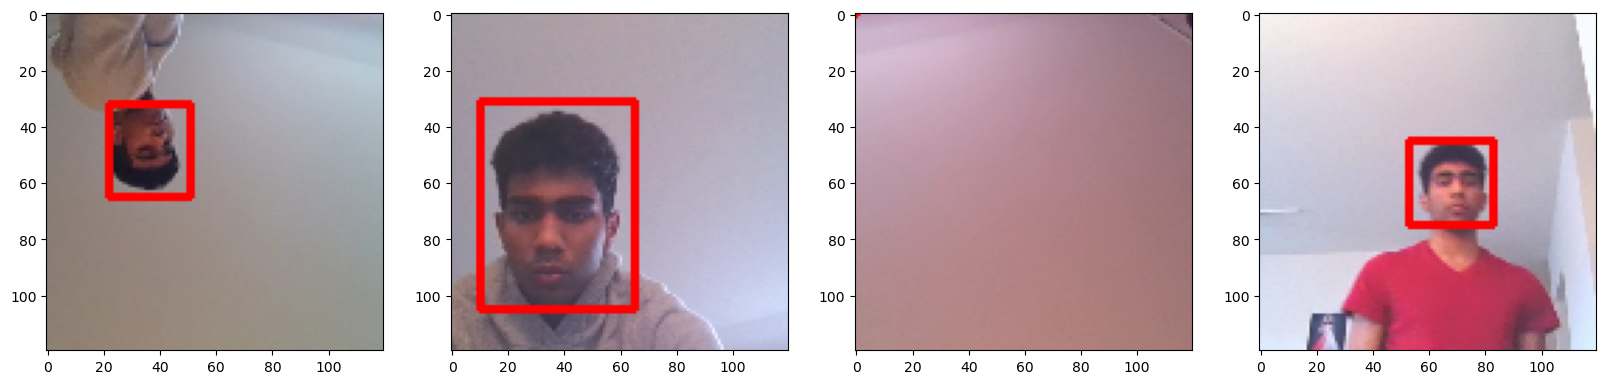

In [19]:
fig, axs = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    sample_image_um = cv2.UMat(sample_image)

    top_left = tuple(np.multiply(sample_coords[:2], [120,120]).astype(int))
    bottom_right = tuple(np.multiply(sample_coords[2:], [120,120]).astype(int))
                     
    cv2.rectangle(sample_image_um, top_left, bottom_right, (255,0,0), 2)
    
    sample_image_with_rect = sample_image_um.get()
    axs[idx].imshow(sample_image_with_rect)

plt.show()

<h2>Import Layers and Base Network</h2>

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [21]:
vgg = VGG16(include_top=False)

In [22]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

<h2>Build Model</h2>

In [23]:
def build_model():
    input_layer = Input(shape=(120,120,3))

    vgg = VGG16(include_top=False)(input_layer)

    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation="relu")(f1)
    class2 = Dense(1, activation="sigmoid")(class1)

    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation="relu")(f2)
    regress2 = Dense(4, activation="sigmoid")(regress1)

    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [24]:
facetracker = build_model()

In [25]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

<h2>Test Prediction</h2>

In [26]:
X, y = train.as_numpy_iterator().next()

In [27]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 1s 521ms/step


In [28]:
classes, coords

(array([[0.67682165],
        [0.7092353 ],
        [0.6974108 ],
        [0.6793283 ],
        [0.74153966],
        [0.648203  ],
        [0.6871266 ],
        [0.69931763]], dtype=float32),
 array([[0.47281966, 0.78270143, 0.58158326, 0.5071253 ],
        [0.5254319 , 0.7191701 , 0.6271311 , 0.41678056],
        [0.58026224, 0.70911   , 0.57692885, 0.4403873 ],
        [0.4964589 , 0.7652656 , 0.61868966, 0.49116555],
        [0.5679722 , 0.76564854, 0.4935529 , 0.40772966],
        [0.52106446, 0.7226783 , 0.6079476 , 0.48408958],
        [0.4837185 , 0.72113717, 0.64167917, 0.4429193 ],
        [0.50137967, 0.736542  , 0.58872795, 0.48634103]], dtype=float32))

<h2>Define Losses and Optimizers</h2>

In [29]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 - 1)/batches_per_epoch

In [30]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

In [31]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))

    return delta_coord + delta_size

In [32]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

<h2>Test Losses</h2>

In [33]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.3738513>

In [34]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.3683013>

<h2>Train Model</h2>

In [35]:
class FaceTracker(Model):
    def __init__(self, facetracker, **kwargs):
        super().__init__(**kwargs)
        self.model = facetracker

    def compile(self, opt, classloss, regressloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.rloss = regressloss
        self.opt = opt

    def train_step(self, batch, **kwargs):

        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            batch_classloss = self.closs(y[0], classes)
            batch_regressloss = self.rloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_regressloss + (0.5 * batch_classloss)

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_regressloss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=False)

        batch_classloss = self.closs(y[0], classes)
        batch_regressloss = self.rloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_regressloss + (0.5 * batch_classloss)
        
        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_regressloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)


In [36]:
model = FaceTracker(facetracker)

In [37]:
model.compile(opt, classloss, regressloss)

In [38]:
logdir = "logs"

In [39]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [40]:
hist = model.fit(train, 
                 epochs=20, 
                 validation_data=val, 
                 callbacks=[tensorboard_callback])

Epoch 1/20
638/638 [==============================] - 897s 1s/step - total_loss: 0.2173 - class_loss: 0.0502 - regress_loss: 0.1922 - val_total_loss: 0.3297 - val_class_loss: 0.0219 - val_regress_loss: 0.3187
Epoch 2/20
638/638 [==============================] - 1096s 2s/step - total_loss: 0.0785 - class_loss: 0.0208 - regress_loss: 0.0681 - val_total_loss: 0.0462 - val_class_loss: 0.0059 - val_regress_loss: 0.0433
Epoch 3/20
638/638 [==============================] - 1195s 2s/step - total_loss: 0.0509 - class_loss: 0.0135 - regress_loss: 0.0442 - val_total_loss: 0.0630 - val_class_loss: 1.4214e-04 - val_regress_loss: 0.0629
Epoch 4/20


2024-02-24 10:29:10.083753: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:20: Filling up shuffle buffer (this may take a while): 1246 of 6000
2024-02-24 10:29:20.081195: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:20: Filling up shuffle buffer (this may take a while): 2543 of 6000
2024-02-24 10:29:38.326356: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


638/638 [==============================] - 1234s 2s/step - total_loss: 0.0367 - class_loss: 0.0121 - regress_loss: 0.0306 - val_total_loss: 0.3039 - val_class_loss: 0.2889 - val_regress_loss: 0.1594
Epoch 5/20
638/638 [==============================] - 1164s 2s/step - total_loss: 0.0348 - class_loss: 0.0105 - regress_loss: 0.0296 - val_total_loss: 0.0290 - val_class_loss: 2.4468e-05 - val_regress_loss: 0.0290
Epoch 6/20
638/638 [==============================] - 1246s 2s/step - total_loss: 0.0185 - class_loss: 0.0047 - regress_loss: 0.0161 - val_total_loss: 0.0236 - val_class_loss: 0.0017 - val_regress_loss: 0.0227
Epoch 7/20
638/638 [==============================] - 1173s 2s/step - total_loss: 0.0232 - class_loss: 0.0068 - regress_loss: 0.0198 - val_total_loss: 0.0167 - val_class_loss: 9.3594e-04 - val_regress_loss: 0.0162
Epoch 8/20
638/638 [==============================] - 1238s 2s/step - total_loss: 0.0175 - class_loss: 0.0052 - regress_loss: 0.0149 - val_total_loss: 0.0193 - val

2024-02-24 14:27:29.654138: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:20: Filling up shuffle buffer (this may take a while): 1362 of 6000
2024-02-24 14:27:39.647002: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:20: Filling up shuffle buffer (this may take a while): 2763 of 6000
2024-02-24 14:27:56.467338: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


638/638 [==============================] - 1276s 2s/step - total_loss: 0.0040 - class_loss: 7.2521e-05 - regress_loss: 0.0039 - val_total_loss: 0.0198 - val_class_loss: 6.7229e-05 - val_regress_loss: 0.0198
Epoch 17/20
638/638 [==============================] - 1208s 2s/step - total_loss: 0.0039 - class_loss: 5.0303e-05 - regress_loss: 0.0039 - val_total_loss: 0.0683 - val_class_loss: 7.9126e-06 - val_regress_loss: 0.0683
Epoch 18/20
638/638 [==============================] - 1305s 2s/step - total_loss: 0.0035 - class_loss: 3.9225e-05 - regress_loss: 0.0035 - val_total_loss: 0.0285 - val_class_loss: 4.5821e-06 - val_regress_loss: 0.0285
Epoch 19/20
638/638 [==============================] - 1277s 2s/step - total_loss: 0.0031 - class_loss: 2.5336e-05 - regress_loss: 0.0031 - val_total_loss: 0.0150 - val_class_loss: 4.9919e-06 - val_regress_loss: 0.0150
Epoch 20/20
638/638 [==============================] - 1213s 2s/step - total_loss: 0.0029 - class_loss: 2.0623e-05 - regress_loss: 0.002

<h2>Save Model</h2>

In [41]:
from tensorflow.keras.models import load_model

In [42]:
facetracker.save(os.path.join("model", "facetracker.h5"))

/home/augustine/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<h2>Plot Graphs

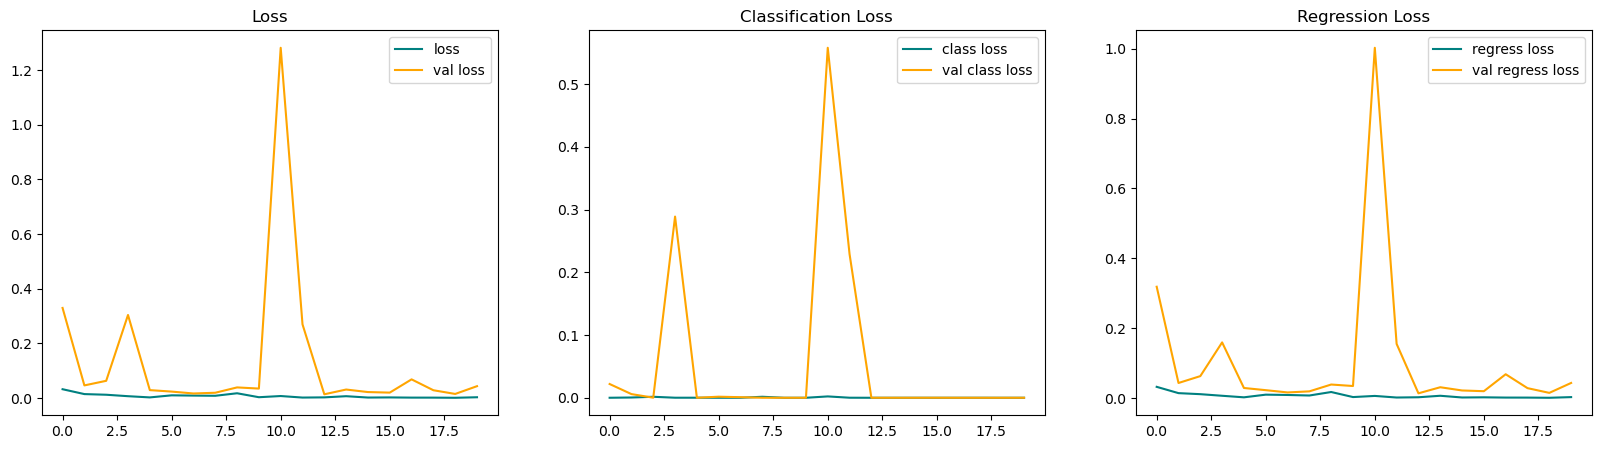

In [43]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()


<h2>Test Data

In [51]:
test_data = test.as_numpy_iterator()

In [78]:
test_sample = test_data.next()

In [79]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 235ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


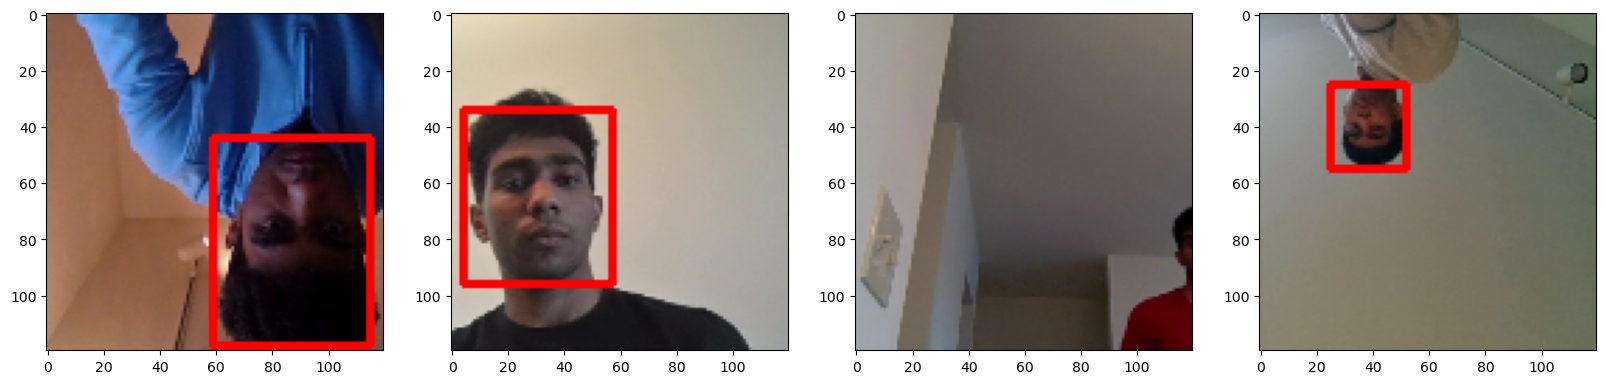

In [80]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]

    sample_image_um = cv2.UMat(sample_image)
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image_um, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
        
    sample_image_with_rect = sample_image_um.get()
    ax[idx].imshow(sample_image_with_rect)